# Recurrent Neural Networks

Recurrent neural networks are simply networks that can have connections going backward in the network, unlike the nets we have seen so far.

Here, we introduce an idea of timesteps where we input a datapoint to the net at each timestep. As a datapoint passes through an RNN, it will proceed to the output layer but the information being sent through the reverse connections will be fed into the net while the next datapoint is passed through the RNN.

## Why Are Backward Connections Useful?

The way RNNs operate means the current datapoint will receive information derived from the previous datapoint since weights will persist and feed information into the net as a new datapoint goes through the net.

The prior information continues to influence how the net operates because, at a third timestep, the information will continue going through the loops in the network architecture, the same at the fourth step, and so on. Therefore, a fundamental difference between RNNs and the nets we have seen in the past is this persistent "memory" of previous datapoints, which allows us to use context of the previous datapoints to make inferences about each datapoint.

### Examples

If we have a paragraph of text, we could feed it into the net word-by-word and try to classify the whole sequence. It gives us the power of using the *context* built by the other words in the paragraph. Any use of language, such as recognizing spoken words, handwritten text, or sign language, can benefit from this.

In addition, in handwriting recognition where we have a whole word of text, certainly knowing some letters in the word can help you figure out an unknown letter in the center. For example, if we have a K, it is very very unlikely the next letter will be a Q in English. For another example, here's a word I wrote:

![img](feature.png)

Obviously, being an intelligent human, you know the third letter is an 'a' and not a 'u' because "feuture" isn't a word and your professor has passable spelling skills. However, looking at that letter in isolation makes its identity totally ambiguous. Letter/digit recognition is the kind of task we have assigned to neural nets before, but RNNs have a more unique ability to read letters one-by-one, and use the past letters to influence later classifications.

The commonality in all of these examples is that they all involve making inferences about *sequences* of inputs (letters, words, signs), rather than just individual inputs.

Note that we are talking only of new datapoints being influenced by prior datapoints, but we will also learn about bidirectional RNNs, which look both forward and backward in time by distances the net will learn.

Of course, CNNs also use local structure within datapoints to make inferences about the whole datapoint too, but we have to specify what size filters and how many filters to use for this. With RNNs, the net will automatically learn to use as much of the past information as it needs to use for a given point.

## Training RNNs

The most common approach to training RNNs is essentially the same as any other neural net we have seen: stochastic gradient descent and backpropagation. SGD will operate just the same as the other nets. Recall we have used backpropagation to compute exact gradients needed by SGD by systematic use of the chain rule propagating backwards from the loss function to the weights and biases in the network.

RNNs present a challenge to this idea--what does it mean to propagate backwards in a net that has loops?! There would be infinite paths the method could take since there are loops it could traverse arbitrarily many times.

## Sentiment Analysis

One area of application of RNNs is in sentiment analysis--attempts to identify the feelings associated with written text. Examples:

* Is a review of a product or service or song or movie positive, neutral, or negative?
* Was someone happy or sad in describing their day?
* Are song lyrics sad or happy or excited?

### Movie Reviews

Let's see what we can do with movie reviews for an experiment in sentiment analysis. The data comes from the Internet Movie Database (IMBD), provided by

* Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). *The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)*.

The dataset contains 50,000 reviews (half in a training set, half in a testing set). Each dataset has reviews from disjoint sets of movies, at most 30 per movie. Each review on IMDB includes a rating from 0 to 10, but the data includes only negative reviews ($\leq 4$ rating) and positive reviews ($\geq 6$ rating) as the labels for the datapoints.

We will use the dataset to try to classify the reviews as positive or negative.

In [1]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import zipfile

In [5]:
# unzip the imdb dataset
with zipfile.ZipFile('../datasets/imdb.zip', 'r') as zip_ref:
    zip_ref.extractall('../datasets/imdb/')

In [125]:
# clean the data by removing linebreaks
def prepareData(dir):
    # read the directory of datapoints and labels into a Dataset object
    data = text_dataset_from_directory(dir)
    
    # replace HTML linebreaks from the text with spaces
    return data.map(lambda text, label: (regex_replace(text, '<br />', ' '), label))

# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
# randomly print a review and label
for text_batch, label_batch in trainData.take(1):
    print(text_batch.numpy()[0])
    print(label_batch.numpy()[0]) # 0 = negative, 1 = positive

b'I have watched some pretty poor films in the past, but what the hell were they thinking of when they made this movie. Had the production crew turned into zombies when they came up with the idea of making it, because you sure have to be brain dead to find any enjoyment in it.  I am a fan of most genres and enjoy "shoot \'em up" games, but merging the daft scenes from the game just made this ridiculous and unwatchable.  As most have already said, there was hardly any script and the acting was weak. I won\'t waste my time describing it.  Anyone who rates this film above 4 has to be part of the production company or Sega, or else they have a very warped concept of entertainment.  I must say, I was more annoyed with the video shop, who gave this a thumbs up, which led me to rent it. Thank god I had a second film to watch to restore some of my faith in movies.  Comic book guy would be right if he said "Worst movie ever"!'
0


Next, we will run some experiments on small, comparable nets of some different types.

#### Fully-Connected Net Experiments

First, we create a layer that will vectorize our text into integer values corresponding to each word. This layer will be used in the upcoming experiments. Running this code block will do some preprocessing to customize the layer to our specific dataset.

Then, we continue to build a net with this layer.

In [126]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a dense layer
model.add(Dense(64, activation = 'relu'))

# add a dense layer
model.add(Dense(64, activation = 'relu'))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [127]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_5 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_40 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
dense_76 (Dense)             (None, 100, 64)           8256      
_________________________________________________________________
dense_77 (Dense)             (None, 100, 64)           4160      
_________________________________________________________________
dense_78 (Dense)             (None, 100, 1)            65        
Total params: 140,609
Trainable params: 140,609
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
782/782 [==============================] - 38s 48ms/step - loss: 0.6884 - accuracy: 0.5285 - val_loss: 0.6856 - val_accuracy: 0.5380
Epoch 2/10
782/782 [==============================] - 37s 48ms/step - loss: 0.6853 - accuracy: 0.5391 - val_loss: 0.6855 - val_accuracy: 0.5383
Epoch 3/10
782/782 [==============================] - 37s 48ms/step - loss: 0.6851 - accuracy: 0.5398 - val_loss: 0.6855 - val_accuracy: 0.5384
Epoch 4/10
782/782 [==============================] - 37s 48ms/step - loss: 0.6853 - accuracy: 0.5400 - val_loss: 0.6855 - val_accuracy: 0.5382
Epoch 5/10
782/782 [==============================] - 37s 48ms/step - loss: 0.6851 - accuracy: 0.5406 - val_loss: 0.6855 - val_accuracy: 0.5385
Epoch 6/10
782/782 [==============================] - 37s 48ms/step - loss: 0.6849 - accuracy: 0.5414 - val_loss: 0.6855 - val_accuracy: 0.5384
Epoch 7/10
782/782 [==============================] - 38s 48ms/step - loss: 0.6850 - accuracy: 0.5406 - val_loss: 0.6855 - val_accuracy:

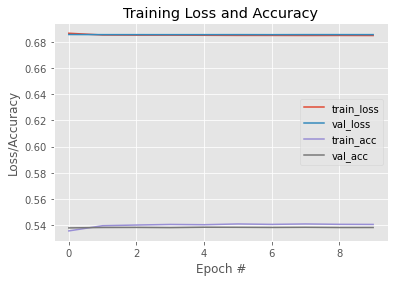

In [128]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [129]:
model.evaluate(testData)

782/782 [==============================] - 18s 23ms/step - loss: 0.6855 - accuracy: 0.5383


[0.6855025291442871, 0.5382867455482483]

Our results here, at 54% are only slightly better than randomly guessing, so this net does not seem very useful for this problem. This makes some sense -- why would a fully-connected net that merely looks at individual words really determine if some text is positive or negative?

#### Convolutional Net Experiment

A convolutional net would look at local structure, so let's try a small CNN.

In [130]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a 1D convolutional layer with 64 filters of length 3
model.add(Conv1D(64, 3, padding ='same', activation = 'relu'))

# add a dense layer
model.add(Dense(64, activation = 'relu'))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [131]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_6 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_41 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 100, 64)           24640     
_________________________________________________________________
dense_79 (Dense)             (None, 100, 64)           4160      
_________________________________________________________________
dense_80 (Dense)             (None, 100, 1)            65        
Total params: 156,993
Trainable params: 156,993
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
782/782 [==============================] - 41s 52ms/step - loss: 0.6802 - accuracy: 0.5553 - val_loss: 0.6725 - val_accuracy: 0.5699
Epoch 2/10
782/782 [==============================] - 41s 52ms/step - loss: 0.6715 - accuracy: 0.5734 - val_loss: 0.6706 - val_accuracy: 0.5733
Epoch 3/10
782/782 [==============================] - 41s 53ms/step - loss: 0.6690 - accuracy: 0.5782 - val_loss: 0.6700 - val_accuracy: 0.5743
Epoch 4/10
782/782 [==============================] - 42s 54ms/step - loss: 0.6665 - accuracy: 0.5827 - val_loss: 0.6694 - val_accuracy: 0.5747
Epoch 5/10
782/782 [==============================] - 43s 55ms/step - loss: 0.6647 - accuracy: 0.5852 - val_loss: 0.6693 - val_accuracy: 0.5751
Epoch 6/10
782/782 [==============================] - 43s 54ms/step - loss: 0.6634 - accuracy: 0.5867 - val_loss: 0.6696 - val_accuracy: 0.5749
Epoch 7/10
782/782 [==============================] - 42s 54ms/step - loss: 0.6614 - accuracy: 0.5900 - val_loss: 0.6703 - val_accuracy:

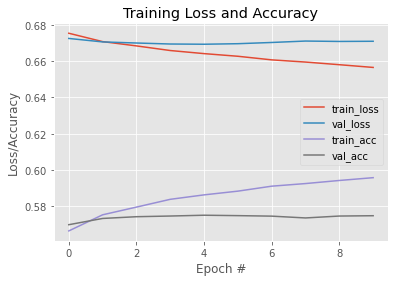

In [132]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [133]:
model.evaluate(testData)

782/782 [==============================] - 19s 24ms/step - loss: 0.6709 - accuracy: 0.5748


[0.6709490418434143, 0.5748365521430969]

In [134]:
for filterSize in range(1,20,2):
    # read the directory into memory and clean the text
    trainData = prepareData('../datasets/imdb/train')
    testData = prepareData('../datasets/imdb/test')

    # create a TextVectorization layer to turn input string into a sequence of integers,
    # each representing one token
    maxTokens = 1000
    vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                       output_mode = 'int',
                                       output_sequence_length = 100)

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    # max_tokens most common words (i.e. the vocabulary) are selected.
    trainText = trainData.map(lambda text, label: text)

    vectorizeLayer.adapt(trainText)
    
    print('Filter size is', filterSize)
    
    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # add layer to the model
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(maxTokens + 1, 128))

    # add a 1D convolutional layer with 64 filters of length 3
    model.add(Conv1D(64, filterSize, padding ='same', activation = 'relu'))

    # add a dense layer
    model.add(Dense(64, activation = 'relu'))

    # add softmax classifier
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    
    model.fit(trainData, epochs = 3)
    
    model.evaluate(testData)

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Filter size is 1
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_7 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 100, 64)           8256      
_________________________________________________________________
dense_81 (Dense)             (None, 100, 64)           4160      
_________________________________________________________________
dense_82 (Dense)             (None, 100, 1)            65        
Total params: 140,609
Trainable params: 140,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
78

In [166]:
class LeNetReg:
    # create the architecture
    def build(classes):
        # create a feedforward neural net
        model = Sequential()

        model.add(Input(shape=(1,), dtype = 'string'))
        
        # add layer to the model
        model.add(vectorizeLayer)

        # add an embedding layer to turn integers into fixed-length vectors
        model.add(Embedding(maxTokens + 1, 128))
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv1D(32, 20, padding = 'same'))
        model.add(Activation('relu'))
        
        #model.add(MaxPooling1D(pool_size = 2, strides = 2))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv1D(64, 20, padding= 'same'))
        model.add(Activation('relu'))
        #model.add(MaxPooling1D(pool_size = 2, strides = 2))
        
        # add another convolutional layer
        model.add(Conv1D(128, 20, padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('sigmoid'))
        
        # return the constructed model
        return model

In [168]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = LeNetReg.build(1)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_26 (TextV (None, 100)               0         
_________________________________________________________________
embedding_61 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 100, 32)           81952     
_________________________________________________________________
activation_45 (Activation)   (None, 100, 32)           0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 100, 64)           41024     
_________________________________________________________________
activation_46 (Activation)   (None, 100, 64)           0         
___________________________________

Epoch 1/10
782/782 [==============================] - 122s 154ms/step - loss: 0.6120 - accuracy: 0.6499 - val_loss: 0.5370 - val_accuracy: 0.7205
Epoch 2/10
782/782 [==============================] - 119s 152ms/step - loss: 0.5176 - accuracy: 0.7397 - val_loss: 0.5109 - val_accuracy: 0.7381
Epoch 3/10
782/782 [==============================] - 115s 147ms/step - loss: 0.4904 - accuracy: 0.7575 - val_loss: 0.5228 - val_accuracy: 0.7285
Epoch 4/10
782/782 [==============================] - 115s 147ms/step - loss: 0.4608 - accuracy: 0.7760 - val_loss: 0.5516 - val_accuracy: 0.7220
Epoch 5/10
782/782 [==============================] - 113s 144ms/step - loss: 0.4194 - accuracy: 0.8023 - val_loss: 0.6267 - val_accuracy: 0.7242
Epoch 6/10
782/782 [==============================] - 110s 141ms/step - loss: 0.3593 - accuracy: 0.8359 - val_loss: 0.7071 - val_accuracy: 0.7083
Epoch 7/10
782/782 [==============================] - 118s 151ms/step - loss: 0.2860 - accuracy: 0.8729 - val_loss: 0.9876 -

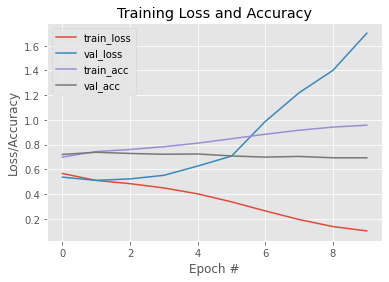

In [169]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [170]:
model.evaluate(testData)

782/782 [==============================] - 27s 34ms/step - loss: 1.7007 - accuracy: 0.6936


[1.7007369995117188, 0.6935557126998901]

#### Recurrent Net Experiments

Here, let's try replacing one of the dense layers from the fully-connected net with a fully-connected recurrent layer and see how the results look.

In [135]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(SimpleRNN(64))

# add a dense layer
model.add(Dense(64, activation = 'relu'))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [136]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_17 (TextV (None, 100)               0         
_________________________________________________________________
embedding_52 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_101 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 65        
Total params: 144,705
Trainable params: 144,705
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
782/782 [==============================] - 45s 56ms/step - loss: 0.6989 - accuracy: 0.4998 - val_loss: 0.6949 - val_accuracy: 0.5084
Epoch 2/10
782/782 [==============================] - 44s 57ms/step - loss: 0.6939 - accuracy: 0.5176 - val_loss: 0.6864 - val_accuracy: 0.5377
Epoch 3/10
782/782 [==============================] - 45s 58ms/step - loss: 0.6713 - accuracy: 0.5854 - val_loss: 0.6700 - val_accuracy: 0.5715
Epoch 4/10
782/782 [==============================] - 45s 58ms/step - loss: 0.6516 - accuracy: 0.6084 - val_loss: 0.6732 - val_accuracy: 0.5816
Epoch 5/10
782/782 [==============================] - 45s 58ms/step - loss: 0.6407 - accuracy: 0.6315 - val_loss: 0.6920 - val_accuracy: 0.5330
Epoch 6/10
782/782 [==============================] - 46s 59ms/step - loss: 0.6830 - accuracy: 0.5498 - val_loss: 0.6891 - val_accuracy: 0.5390
Epoch 7/10
782/782 [==============================] - 45s 57ms/step - loss: 0.6676 - accuracy: 0.5876 - val_loss: 0.6800 - val_accuracy:

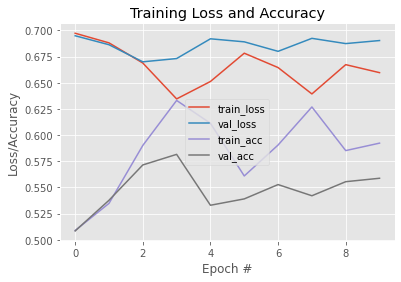

In [137]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [138]:
model.evaluate(testData)

782/782 [==============================] - 20s 26ms/step - loss: 0.6904 - accuracy: 0.5588


[0.6903530955314636, 0.5587599873542786]

As we see, the results are a little better than the fully connected net, but does not perform as well as some of the CNN experiments above.

In [186]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(Bidirectional(SimpleRNN(64)))

# add a dense layer
model.add(Dense(64, activation = 'relu'))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_32 (TextV (None, 100)               0         
_________________________________________________________________
embedding_67 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               24704     
_________________________________________________________________
dense_124 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 65        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 178s 226ms/step - loss: 0.6956 - accuracy: 0.5139 - val_los

[0.5662016868591309, 0.7059199810028076]

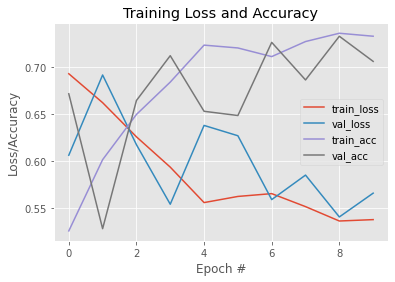

In [187]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

model.evaluate(testData)

In [143]:
print(model.predict(['Watching this film was the worst experience of my life and I would rather die than watch it again.']))

print(model.predict(['The acting is only okay in this movie, but it has an amazing storyline, so I rate it as good but not great.']))

print(model.predict(['Dodgeball is my brother\'s favorite movie, but I hate it']))

print(model.predict(['Dodgeball is my brother\'s favorite movie and it has its moments, but I think the comedy is sophomoric and crude. The acting is great, but the writing is subpar. Overall, I would rate this movie 2/10.']))

print(model.predict(['I love Nicholas Cage, but this movie is horrible. NOT THE BEES.']))

[[0.00585702]]
[[0.93553996]]
[[0.94442177]]
[[0.97756386]]
[[0.00545222]]


#### Experiment With LSTM

In [158]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [159]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_23 (TextV (None, 100)               0         
_________________________________________________________________
embedding_58 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_112 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 65        
Total params: 181,761
Trainable params: 181,761
Non-trainable params: 0
_______________________________________________

Epoch 1/10
782/782 [==============================] - 66s 83ms/step - loss: 0.6128 - accuracy: 0.6372 - val_loss: 0.4736 - val_accuracy: 0.7834
Epoch 2/10
782/782 [==============================] - 65s 83ms/step - loss: 0.4547 - accuracy: 0.7917 - val_loss: 0.4440 - val_accuracy: 0.7949
Epoch 3/10
782/782 [==============================] - 66s 84ms/step - loss: 0.4205 - accuracy: 0.8128 - val_loss: 0.4529 - val_accuracy: 0.7871
Epoch 4/10
782/782 [==============================] - 65s 83ms/step - loss: 0.3948 - accuracy: 0.8306 - val_loss: 0.4479 - val_accuracy: 0.7855
Epoch 5/10
782/782 [==============================] - 65s 82ms/step - loss: 0.3718 - accuracy: 0.8406 - val_loss: 0.4901 - val_accuracy: 0.7907
Epoch 6/10
782/782 [==============================] - 64s 81ms/step - loss: 0.3565 - accuracy: 0.8467 - val_loss: 0.4779 - val_accuracy: 0.7883
Epoch 7/10
782/782 [==============================] - 66s 84ms/step - loss: 0.3465 - accuracy: 0.8505 - val_loss: 0.5323 - val_accuracy:

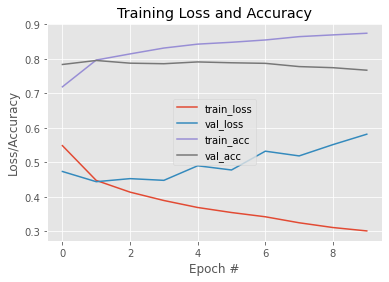

In [160]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [161]:
model.evaluate(testData)

782/782 [==============================] - 25s 32ms/step - loss: 0.5815 - accuracy: 0.7668


[0.5814893245697021, 0.766759991645813]

In [162]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))
model.add(Dropout(0.5))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [163]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_24 (TextV (None, 100)               0         
_________________________________________________________________
embedding_59 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 1)               

Epoch 1/10
782/782 [==============================] - 69s 86ms/step - loss: 0.6605 - accuracy: 0.5875 - val_loss: 0.4789 - val_accuracy: 0.7774
Epoch 2/10
782/782 [==============================] - 67s 86ms/step - loss: 0.4778 - accuracy: 0.7855 - val_loss: 0.4484 - val_accuracy: 0.7860
Epoch 3/10
782/782 [==============================] - 68s 87ms/step - loss: 0.4321 - accuracy: 0.8073 - val_loss: 0.4455 - val_accuracy: 0.7909
Epoch 4/10
782/782 [==============================] - 71s 90ms/step - loss: 0.4064 - accuracy: 0.8247 - val_loss: 0.4475 - val_accuracy: 0.7909
Epoch 5/10
782/782 [==============================] - 70s 90ms/step - loss: 0.3819 - accuracy: 0.8369 - val_loss: 0.4648 - val_accuracy: 0.7844
Epoch 6/10
782/782 [==============================] - 69s 88ms/step - loss: 0.3649 - accuracy: 0.8429 - val_loss: 0.4677 - val_accuracy: 0.7746
Epoch 7/10
782/782 [==============================] - 71s 90ms/step - loss: 0.3461 - accuracy: 0.8547 - val_loss: 0.4759 - val_accuracy:

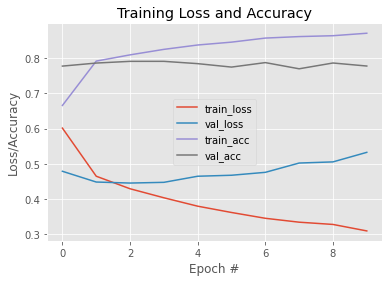

In [164]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [165]:
model.evaluate(testData)

782/782 [==============================] - 26s 33ms/step - loss: 0.5326 - accuracy: 0.7776


[0.5326470732688904, 0.7775999903678894]

In [173]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# the vocabulary is selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64, return_sequences = True))

# add a fully-connected recurrent layer
model.add(LSTM(64))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [174]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_29 (TextV (None, 100)               0         
_________________________________________________________________
embedding_64 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 64)           49408     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_120 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)               

Epoch 1/10
782/782 [==============================] - 97s 121ms/step - loss: 0.5930 - accuracy: 0.6636 - val_loss: 0.4531 - val_accuracy: 0.7901
Epoch 2/10
782/782 [==============================] - 95s 122ms/step - loss: 0.4504 - accuracy: 0.7960 - val_loss: 0.5014 - val_accuracy: 0.7759
Epoch 3/10
782/782 [==============================] - 96s 123ms/step - loss: 0.4152 - accuracy: 0.8162 - val_loss: 0.4606 - val_accuracy: 0.7855
Epoch 4/10
782/782 [==============================] - 96s 123ms/step - loss: 0.3887 - accuracy: 0.8307 - val_loss: 0.5589 - val_accuracy: 0.7642
Epoch 5/10
782/782 [==============================] - 97s 124ms/step - loss: 0.3840 - accuracy: 0.8360 - val_loss: 0.5009 - val_accuracy: 0.7826
Epoch 6/10
782/782 [==============================] - 96s 122ms/step - loss: 0.3509 - accuracy: 0.8526 - val_loss: 0.5331 - val_accuracy: 0.7828
Epoch 7/10
782/782 [==============================] - 96s 122ms/step - loss: 0.3302 - accuracy: 0.8591 - val_loss: 0.5092 - val_ac

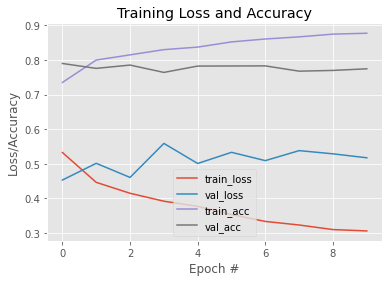

In [175]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [176]:
model.evaluate(testData)

782/782 [==============================] - 34s 43ms/step - loss: 0.5174 - accuracy: 0.7747


[0.51736980676651, 0.7747200131416321]

In [177]:
# read the directory into memory and clean the text
trainData = prepareData('../datasets/imdb/train')
testData = prepareData('../datasets/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# the vocabulary is selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.5))

# add a fully-connected recurrent layer
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [178]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_30 (TextV (None, 100)               0         
_________________________________________________________________
embedding_65 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 64)           49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 64)              

Epoch 1/10
782/782 [==============================] - 101s 125ms/step - loss: 0.6536 - accuracy: 0.5976 - val_loss: 0.4702 - val_accuracy: 0.7821
Epoch 2/10
782/782 [==============================] - 100s 127ms/step - loss: 0.4780 - accuracy: 0.7828 - val_loss: 0.5056 - val_accuracy: 0.7586
Epoch 3/10
782/782 [==============================] - 99s 127ms/step - loss: 0.4400 - accuracy: 0.8040 - val_loss: 0.5203 - val_accuracy: 0.7862
Epoch 4/10
782/782 [==============================] - 99s 127ms/step - loss: 0.4299 - accuracy: 0.8063 - val_loss: 0.4460 - val_accuracy: 0.7972
Epoch 5/10
782/782 [==============================] - 99s 127ms/step - loss: 0.4005 - accuracy: 0.8226 - val_loss: 0.4415 - val_accuracy: 0.8002
Epoch 6/10
782/782 [==============================] - 99s 127ms/step - loss: 0.3773 - accuracy: 0.8334 - val_loss: 0.5001 - val_accuracy: 0.7710
Epoch 7/10
782/782 [==============================] - 100s 127ms/step - loss: 0.3679 - accuracy: 0.8387 - val_loss: 0.4970 - val

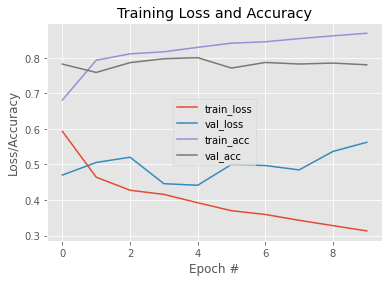

In [179]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [180]:
model.evaluate(testData)

782/782 [==============================] - 35s 44ms/step - loss: 0.5624 - accuracy: 0.78020s - loss: 0.5


[0.5623735189437866, 0.7801600098609924]

In [143]:
print(model.predict(['Watching this film was the worst experience of my life and I would rather die than watch it again.']))

print(model.predict(['The acting is only okay in this movie, but it has an amazing storyline, so I rate it as good but not great.']))

print(model.predict(['Dodgeball is my brother\'s favorite movie, but I hate it']))

print(model.predict(['Dodgeball is my brother\'s favorite movie and it has its moments, but I think the comedy is sophomoric and crude. The acting is great, but the writing is subpar. Overall, I would rate this movie 2/10.']))

print(model.predict(['I love Nicholas Cage, but this movie is horrible. NOT THE BEES.']))

[[0.00585702]]
[[0.93553996]]
[[0.94442177]]
[[0.97756386]]
[[0.00545222]]


In [2]:
# delete the unzipped imdb dataset (this is just so I can upload to GitHub efficiently)
if os.path.isfile('../datasets/imdb/README'):
    shutil.rmtree('../datasets/imdb')